In [14]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve
from sklearn import svm

import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
imagedir = "Datasets/Original"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.ppm'))  # assuming the images are stored as 'ppm'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tClass: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.ppm'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Class:     fraterculus	Number of images: 100
Label: 1	Class:         obliqua	Number of images: 101
Label: 2	Class:       sororcula	Number of images: 100
Processing images ...
Images processed: 301


In [4]:
X.shape

(301, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
list_paths

['/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F035-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F025-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F084-G-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F062-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F021-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F042-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F098-G-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F115-G-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F048-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F010-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F022-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F006-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F055-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F110-G-1,5x.ppm'

In [7]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds
skfind = []
test_fold = np.zeros((num_samples,), dtype=int)-1
for i in range(kfold):
    train_ind = []
    print('Datasets/Folds/Fold-Train%d.txt' %(i+1))
    with open('Datasets/Folds/Fold-Train%d.txt' %(i+1), 'r') as f:
        for fname in f.read().splitlines():
            print('[%d] %s' %(list_paths.index([s for s in list_paths if fname in s][0]),fname))
            train_ind.append(list_paths.index([s for s in list_paths if fname in s][0]))
    print('[%d] Train fold size: %d' %(i,len(train_ind)))
    print(train_ind)
    test_ind = []
    print('Datasets/Folds/Fold-Test%d.txt' %(i+1))
    with open('Datasets/Folds/Fold-Test%d.txt' %(i+1), 'r') as f:
        for fname in f.read().splitlines():
            sample_idx = list_paths.index([s for s in list_paths if fname in s][0])
            print('[%d] %s' %(sample_idx,fname))
            test_ind.append(sample_idx)
            test_fold[sample_idx] = i
    print('[%d] Test fold size: %d' %(i,len(test_ind)))
    print(test_ind)
    #skfind.append((np.array(train_ind),np.array(test_ind)))
    skfind.append((train_ind,test_ind))
print('SKFIND')
print(skfind)
print('TEST_FOLD')
print(test_fold)

Datasets/Folds/Fold-Train1.txt
[11] F006-1,5x.ppm
[66] F009-1,5x.ppm
[68] F016,1,5x.ppm
[10] F022-1,5x.ppm
[33] F027-1,5x.ppm
[30] F033-1,5x.ppm
[39] F037-1,5x.ppm
[67] F041-1,5x.ppm
[77] F050-1,5x.ppm
[96] F054-1,5x.ppm
[41] F063-1,5x.ppm
[23] F072-G-1,5x.ppm
[83] F077-G-1,5x.ppm
[18] F090-G-1,5x.ppm
[44] F093-G-1,5x.ppm
[15] F094-G-1,5x.ppm
[63] F095-G-1,5x.ppm
[99] F106-G-1,5x.ppm
[53] F108-G-1,5x.ppm
[47] F132-N-1,5x.ppm
[254] S093-1,5x.ppm
[216] S094-1,5x.ppm
[288] S095-1,5x.ppm
[213] S096-1,5x.ppm
[279] S098-1,5x.ppm
[207] S099-1,5x.ppm
[209] S100-1,5x.ppm
[259] S101-1,5x.ppm
[300] s102-1,5x.ppm
[268] S103-1,5x.ppm
[278] S104-1,5x.ppm
[251] S105-1,5x.ppm
[267] S106-1,5x.ppm
[281] S108-1,5x.ppm
[244] S109-1,5x.ppm
[229] S111-1,5x.ppm
[247] S112-1,5x.ppm
[208] S116-1,5x.ppm
[261] S118-1,5x.ppm
[234] S123-1,5x.ppm
[131] B001-1,5x.ppm
[193] B003,1,5x.ppm
[140] B009-1,5x.ppm
[167] B012-1,5X.ppm
[195] B018-1,5x.ppm
[162] B019-1,5x.ppm
[158] B024-1,5x.ppm
[110] B032-1,5x.ppm
[137] B038-

[95] F013-1,5x.ppm
[91] F034-1,5x.ppm
[62] F113-G-1,5x.ppm
[2] F084-G-1,5x.ppm
[76] F049-1,5x.ppm
[81] F060-1,5x.ppm
[43] F075-G-1,5x.ppm
[71] F097-G-1,5x.ppm
[17] F004-1,5x.ppm
[55] F039-1,5x.ppm
[88] F061-1,5x.ppm
[42] F080-G-1,5x.ppm
[19] F026-1,5x.ppm
[87] F064-1,5x.ppm
[20] F028-1,5x.ppm
[97] F056-1,5x.ppm
[94] F091-G-1,5x.ppm
[8] F048-1,5x.ppm
[262] S001-1,5x.ppm
[245] S003-1,5x.ppm
[257] S004-1,5x.ppm
[250] S005-1,5x.ppm
[291] S006-1,5x.ppm
[285] S007-1,5x.ppm
[290] S008-1,5x.ppm
[274] S009-1,5x.ppm
[226] S010-1,5x.ppm
[205] S011-1,5x.ppm
[232] S012-1,5x.ppm
[228] S015-1,5x.ppm
[203] S016-1,5x.ppm
[240] S018-1,5x.ppm
[242] S019-1,5x.ppm
[282] S020-1,5x.ppm
[211] S021-1,5x.ppm
[271] S022-1,5x.ppm
[294] S023-1,5x.ppm
[224] S024-1,5x.ppm
[152] B077-G-1,5x.ppm
[176] B074-G-1,5x.ppm
[160] B056-1,5x.ppm
[155] B061-M-1,5x.ppm
[189] B020-1,5x.ppm
[180] B015-1,5x.ppm
[146] B101-G-1,5x.ppm
[126] B082-G-1,5x.ppm
[115] B093-G-1,5x.ppm
[182] B042-1,5x.ppm
[166] B062-G-1,5x.ppm
[141] B002-1,5

In [8]:
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
model = ResNet50(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
filename = 'moscas-folds-resnet50-init_weights.npy'
if os.path.exists(filename):
    print("Loading ResNet50 initial weights from %s ..." %(filename))
    init_weights = np.load(filename)
else:
    print("Generating ResNet50 initial weigths ...")
    init_weights = model.get_weights()
    print("Saving ResNet50 initial weights into %s ..." %(filename))
    np.save(filename, init_weights)

Loading ResNet50 initial weights from moscas-folds-resnet50-init_weights.npy ...


In [10]:
# Training the model from scratch
num_epochs=200
history = []
checkpointer = ModelCheckpoint(filepath='moscas-folds-resnet50-Adam-%depochs-fromscratch-weights.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 241 samples, validate on 60 samples
Epoch 1/200
241/241 [==============================] - 16s - loss: 2.2915 - acc: 0.4274 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 2/200
241/241 [==============================] - 2s - loss: 1.9714 - acc: 0.6805 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 3/200
241/241 [==============================] - 2s - loss: 0.7527 - acc: 0.7925 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 4/200
241/241 [==============================] - 2s - loss: 0.2257 - acc: 0.9004 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 5/200
241/241 [==============================] - 2s - loss: 0.1504 - acc: 0.9212 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 6/200
241/241 [==============================] - 2s - loss: 0.1233 - acc: 0.9502 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 7/200
241/241 [==============================] - 2s - loss: 0.0555 - acc: 0.9917 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 8/200
241/241 [==============================] - 2s - loss: 0.0135 - acc:

241/241 [==============================] - 2s - loss: 1.6848e-05 - acc: 1.0000 - val_loss: 7.2651 - val_acc: 0.3333
Epoch 65/200
241/241 [==============================] - 2s - loss: 2.1078e-05 - acc: 1.0000 - val_loss: 7.1944 - val_acc: 0.3333
Epoch 66/200
241/241 [==============================] - 2s - loss: 4.8557e-06 - acc: 1.0000 - val_loss: 7.1166 - val_acc: 0.3333
Epoch 67/200
241/241 [==============================] - 2s - loss: 4.7350e-06 - acc: 1.0000 - val_loss: 7.0319 - val_acc: 0.3333
Epoch 68/200
241/241 [==============================] - 2s - loss: 7.1647e-06 - acc: 1.0000 - val_loss: 6.9399 - val_acc: 0.3333
Epoch 69/200
241/241 [==============================] - 2s - loss: 7.7360e-06 - acc: 1.0000 - val_loss: 6.8382 - val_acc: 0.3500
Epoch 70/200
241/241 [==============================] - 2s - loss: 8.8813e-06 - acc: 1.0000 - val_loss: 6.7280 - val_acc: 0.3500
Epoch 71/200
241/241 [==============================] - 2s - loss: 1.0026e-05 - acc: 1.0000 - val_loss: 6.6120

241/241 [==============================] - 2s - loss: 4.4047e-06 - acc: 1.0000 - val_loss: 2.1679 - val_acc: 0.6833
Epoch 128/200
241/241 [==============================] - 3s - loss: 2.2336e-06 - acc: 1.0000 - val_loss: 2.1553 - val_acc: 0.7000
Epoch 129/200
241/241 [==============================] - 2s - loss: 1.8935e-06 - acc: 1.0000 - val_loss: 2.1423 - val_acc: 0.7000
Epoch 130/200
241/241 [==============================] - 2s - loss: 2.3273e-06 - acc: 1.0000 - val_loss: 2.1310 - val_acc: 0.7000
Epoch 131/200
241/241 [==============================] - 2s - loss: 1.9477e-06 - acc: 1.0000 - val_loss: 2.1176 - val_acc: 0.7000
Epoch 132/200
241/241 [==============================] - 2s - loss: 3.1729e-06 - acc: 1.0000 - val_loss: 2.1043 - val_acc: 0.7000
Epoch 133/200
241/241 [==============================] - 2s - loss: 2.4166e-06 - acc: 1.0000 - val_loss: 2.0937 - val_acc: 0.7000
Epoch 134/200
241/241 [==============================] - 2s - loss: 3.9288e-06 - acc: 1.0000 - val_loss:

241/241 [==============================] - 2s - loss: 4.5098e-06 - acc: 1.0000 - val_loss: 1.9510 - val_acc: 0.7833
Epoch 191/200
241/241 [==============================] - 2s - loss: 2.4147e-06 - acc: 1.0000 - val_loss: 1.9495 - val_acc: 0.8000
Epoch 192/200
241/241 [==============================] - 2s - loss: 1.2660e-06 - acc: 1.0000 - val_loss: 1.9496 - val_acc: 0.8000
Epoch 193/200
241/241 [==============================] - 2s - loss: 1.3692e-06 - acc: 1.0000 - val_loss: 1.9501 - val_acc: 0.8000
Epoch 194/200
241/241 [==============================] - 2s - loss: 4.5039e-06 - acc: 1.0000 - val_loss: 1.9493 - val_acc: 0.8000
Epoch 195/200
241/241 [==============================] - 2s - loss: 1.3519e-06 - acc: 1.0000 - val_loss: 1.9495 - val_acc: 0.8000
Epoch 196/200
241/241 [==============================] - 2s - loss: 4.2062e-06 - acc: 1.0000 - val_loss: 1.9490 - val_acc: 0.8000
Epoch 197/200
241/241 [==============================] - 2s - loss: 6.0179e-06 - acc: 1.0000 - val_loss:

240/240 [==============================] - 2s - loss: 1.6600e-04 - acc: 1.0000 - val_loss: 1.4931 - val_acc: 0.7213
Epoch 54/200
240/240 [==============================] - 2s - loss: 1.7017e-04 - acc: 1.0000 - val_loss: 1.4674 - val_acc: 0.7213
Epoch 55/200
240/240 [==============================] - 2s - loss: 1.1391e-04 - acc: 1.0000 - val_loss: 1.4371 - val_acc: 0.7377
Epoch 56/200
240/240 [==============================] - 2s - loss: 7.0185e-05 - acc: 1.0000 - val_loss: 1.4075 - val_acc: 0.7377
Epoch 57/200
240/240 [==============================] - 2s - loss: 3.2312e-04 - acc: 1.0000 - val_loss: 1.3673 - val_acc: 0.7213
Epoch 58/200
240/240 [==============================] - 2s - loss: 1.7564e-04 - acc: 1.0000 - val_loss: 1.3018 - val_acc: 0.7213
Epoch 59/200
240/240 [==============================] - 2s - loss: 7.1290e-05 - acc: 1.0000 - val_loss: 1.2499 - val_acc: 0.7541
Epoch 60/200
240/240 [==============================] - 2s - loss: 5.4749e-04 - acc: 1.0000 - val_loss: 1.2342

240/240 [==============================] - 2s - loss: 4.0899e-05 - acc: 1.0000 - val_loss: 1.3047 - val_acc: 0.7541
Epoch 117/200
240/240 [==============================] - 2s - loss: 0.0098 - acc: 0.9958 - val_loss: 1.0912 - val_acc: 0.8033
Epoch 118/200
240/240 [==============================] - 2s - loss: 0.0082 - acc: 0.9958 - val_loss: 0.5998 - val_acc: 0.9180
Epoch 119/200
240/240 [==============================] - 2s - loss: 0.0169 - acc: 0.9917 - val_loss: 0.5525 - val_acc: 0.8852
Epoch 120/200
240/240 [==============================] - 2s - loss: 0.0269 - acc: 0.9833 - val_loss: 0.5365 - val_acc: 0.8689
Epoch 121/200
240/240 [==============================] - 2s - loss: 0.1066 - acc: 0.9792 - val_loss: 3.0007 - val_acc: 0.6230
Epoch 122/200
240/240 [==============================] - 2s - loss: 0.0609 - acc: 0.9708 - val_loss: 3.2762 - val_acc: 0.7213
Epoch 123/200
240/240 [==============================] - 2s - loss: 0.0523 - acc: 0.9792 - val_loss: 5.0114 - val_acc: 0.5574
Ep

240/240 [==============================] - 2s - loss: 2.7038e-05 - acc: 1.0000 - val_loss: 0.8161 - val_acc: 0.8361
Epoch 180/200
240/240 [==============================] - 2s - loss: 1.9939e-05 - acc: 1.0000 - val_loss: 0.8112 - val_acc: 0.8361
Epoch 181/200
240/240 [==============================] - 2s - loss: 2.4276e-05 - acc: 1.0000 - val_loss: 0.7998 - val_acc: 0.8525
Epoch 182/200
240/240 [==============================] - 2s - loss: 3.0504e-05 - acc: 1.0000 - val_loss: 0.7851 - val_acc: 0.8525
Epoch 183/200
240/240 [==============================] - 2s - loss: 5.9990e-05 - acc: 1.0000 - val_loss: 0.7695 - val_acc: 0.8525
Epoch 184/200
240/240 [==============================] - 2s - loss: 2.7231e-05 - acc: 1.0000 - val_loss: 0.7544 - val_acc: 0.8852
Epoch 185/200
240/240 [==============================] - 2s - loss: 2.1613e-05 - acc: 1.0000 - val_loss: 0.7403 - val_acc: 0.8852
Epoch 186/200
240/240 [==============================] - 2s - loss: 1.8630e-05 - acc: 1.0000 - val_loss:

241/241 [==============================] - 2s - loss: 1.6297e-04 - acc: 1.0000 - val_loss: 10.0315 - val_acc: 0.3333
Epoch 43/200
241/241 [==============================] - 2s - loss: 2.9473e-04 - acc: 1.0000 - val_loss: 9.3566 - val_acc: 0.3333
Epoch 44/200
241/241 [==============================] - 2s - loss: 7.2408e-04 - acc: 1.0000 - val_loss: 8.6612 - val_acc: 0.3500
Epoch 45/200
241/241 [==============================] - 2s - loss: 2.5686e-04 - acc: 1.0000 - val_loss: 8.0121 - val_acc: 0.3667
Epoch 46/200
241/241 [==============================] - 2s - loss: 1.7642e-04 - acc: 1.0000 - val_loss: 7.1905 - val_acc: 0.3667
Epoch 47/200
241/241 [==============================] - 2s - loss: 3.0044e-04 - acc: 1.0000 - val_loss: 6.1607 - val_acc: 0.3833
Epoch 48/200
241/241 [==============================] - 2s - loss: 3.6282e-04 - acc: 1.0000 - val_loss: 5.2153 - val_acc: 0.4333
Epoch 49/200
241/241 [==============================] - 2s - loss: 6.4537e-04 - acc: 1.0000 - val_loss: 4.111

241/241 [==============================] - 2s - loss: 2.4343e-05 - acc: 1.0000 - val_loss: 0.7929 - val_acc: 0.9167
Epoch 106/200
241/241 [==============================] - 2s - loss: 3.2693e-05 - acc: 1.0000 - val_loss: 0.7931 - val_acc: 0.9167
Epoch 107/200
241/241 [==============================] - 2s - loss: 2.9982e-05 - acc: 1.0000 - val_loss: 0.7914 - val_acc: 0.9167
Epoch 108/200
241/241 [==============================] - 2s - loss: 7.6476e-05 - acc: 1.0000 - val_loss: 0.7908 - val_acc: 0.9167
Epoch 109/200
241/241 [==============================] - 2s - loss: 5.4632e-05 - acc: 1.0000 - val_loss: 0.7930 - val_acc: 0.9167
Epoch 110/200
241/241 [==============================] - 2s - loss: 9.2244e-05 - acc: 1.0000 - val_loss: 0.7915 - val_acc: 0.9167
Epoch 111/200
241/241 [==============================] - 2s - loss: 4.2606e-05 - acc: 1.0000 - val_loss: 0.7904 - val_acc: 0.9167
Epoch 112/200
241/241 [==============================] - 2s - loss: 4.4496e-05 - acc: 1.0000 - val_loss:

241/241 [==============================] - 2s - loss: 1.9441e-05 - acc: 1.0000 - val_loss: 0.8116 - val_acc: 0.9167
Epoch 169/200
241/241 [==============================] - 2s - loss: 2.9762e-05 - acc: 1.0000 - val_loss: 0.8126 - val_acc: 0.9167
Epoch 170/200
241/241 [==============================] - 2s - loss: 2.2882e-05 - acc: 1.0000 - val_loss: 0.8135 - val_acc: 0.9167
Epoch 171/200
241/241 [==============================] - 2s - loss: 1.5423e-05 - acc: 1.0000 - val_loss: 0.8158 - val_acc: 0.9167
Epoch 172/200
241/241 [==============================] - 2s - loss: 1.9622e-05 - acc: 1.0000 - val_loss: 0.8166 - val_acc: 0.9167
Epoch 173/200
241/241 [==============================] - 2s - loss: 1.2162e-04 - acc: 1.0000 - val_loss: 0.8281 - val_acc: 0.9167
Epoch 174/200
241/241 [==============================] - 2s - loss: 9.7097e-06 - acc: 1.0000 - val_loss: 0.8356 - val_acc: 0.9167
Epoch 175/200
241/241 [==============================] - 2s - loss: 1.9651e-05 - acc: 1.0000 - val_loss:

241/241 [==============================] - 2s - loss: 0.0055 - acc: 0.9959 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 32/200
241/241 [==============================] - 2s - loss: 8.6479e-04 - acc: 1.0000 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 33/200
241/241 [==============================] - 2s - loss: 0.0047 - acc: 1.0000 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 34/200
241/241 [==============================] - 2s - loss: 0.0015 - acc: 1.0000 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 35/200
241/241 [==============================] - 2s - loss: 0.0042 - acc: 1.0000 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 36/200
241/241 [==============================] - 2s - loss: 0.0011 - acc: 1.0000 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 37/200
241/241 [==============================] - 2s - loss: 0.0027 - acc: 1.0000 - val_loss: 10.6378 - val_acc: 0.3333
Epoch 38/200
241/241 [==============================] - 2s - loss: 0.0015 - acc: 1.0000 - val_loss: 10.4417 - val_acc: 0.3333
E

241/241 [==============================] - 2s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.8020 - val_acc: 0.8667
Epoch 96/200
241/241 [==============================] - 2s - loss: 8.2647e-05 - acc: 1.0000 - val_loss: 0.8125 - val_acc: 0.8500
Epoch 97/200
241/241 [==============================] - 2s - loss: 2.9633e-04 - acc: 1.0000 - val_loss: 0.8524 - val_acc: 0.8500
Epoch 98/200
241/241 [==============================] - 2s - loss: 3.7091e-04 - acc: 1.0000 - val_loss: 0.8717 - val_acc: 0.8500
Epoch 99/200
241/241 [==============================] - 2s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.9397 - val_acc: 0.8500
Epoch 100/200
241/241 [==============================] - 2s - loss: 5.6375e-05 - acc: 1.0000 - val_loss: 1.1173 - val_acc: 0.7667
Epoch 101/200
241/241 [==============================] - 2s - loss: 8.5062e-05 - acc: 1.0000 - val_loss: 1.2215 - val_acc: 0.7667
Epoch 102/200
241/241 [==============================] - 2s - loss: 2.3655e-04 - acc: 1.0000 - val_loss: 1.2602 - va

241/241 [==============================] - 2s - loss: 2.5141e-05 - acc: 1.0000 - val_loss: 0.6116 - val_acc: 0.9000
Epoch 159/200
241/241 [==============================] - 2s - loss: 3.8989e-05 - acc: 1.0000 - val_loss: 0.6099 - val_acc: 0.9000
Epoch 160/200
241/241 [==============================] - 2s - loss: 2.3490e-05 - acc: 1.0000 - val_loss: 0.6091 - val_acc: 0.9000
Epoch 161/200
241/241 [==============================] - 2s - loss: 2.4787e-05 - acc: 1.0000 - val_loss: 0.6072 - val_acc: 0.9000
Epoch 162/200
241/241 [==============================] - 2s - loss: 2.2852e-05 - acc: 1.0000 - val_loss: 0.6059 - val_acc: 0.9000
Epoch 163/200
241/241 [==============================] - 2s - loss: 4.7419e-05 - acc: 1.0000 - val_loss: 0.6055 - val_acc: 0.9000
Epoch 164/200
241/241 [==============================] - 2s - loss: 1.8585e-05 - acc: 1.0000 - val_loss: 0.6048 - val_acc: 0.9000
Epoch 165/200
241/241 [==============================] - 2s - loss: 1.8377e-05 - acc: 1.0000 - val_loss:

241/241 [==============================] - 2s - loss: 0.1154 - acc: 0.9502 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 21/200
241/241 [==============================] - 2s - loss: 0.1052 - acc: 0.9627 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 22/200
241/241 [==============================] - 2s - loss: 0.0659 - acc: 0.9710 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 23/200
241/241 [==============================] - 2s - loss: 0.0560 - acc: 0.9793 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 24/200
241/241 [==============================] - 2s - loss: 0.0677 - acc: 0.9710 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 25/200
241/241 [==============================] - 2s - loss: 0.1720 - acc: 0.9502 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 26/200
241/241 [==============================] - 2s - loss: 0.0851 - acc: 0.9668 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 27/200
241/241 [==============================] - 2s - loss: 0.0594 - acc: 0.9876 - val_loss: 10.7454 - val_acc: 0.3333
Epoch

241/241 [==============================] - 2s - loss: 8.2307e-05 - acc: 1.0000 - val_loss: 0.6978 - val_acc: 0.8000
Epoch 85/200
241/241 [==============================] - 2s - loss: 1.0051e-04 - acc: 1.0000 - val_loss: 0.6259 - val_acc: 0.8167
Epoch 86/200
241/241 [==============================] - 2s - loss: 4.0280e-04 - acc: 1.0000 - val_loss: 0.5729 - val_acc: 0.8500
Epoch 87/200
241/241 [==============================] - 2s - loss: 1.0319e-04 - acc: 1.0000 - val_loss: 0.5348 - val_acc: 0.8500
Epoch 88/200
241/241 [==============================] - 2s - loss: 5.7053e-05 - acc: 1.0000 - val_loss: 0.4914 - val_acc: 0.8500
Epoch 89/200
241/241 [==============================] - 2s - loss: 1.3925e-04 - acc: 1.0000 - val_loss: 0.4517 - val_acc: 0.8500
Epoch 90/200
241/241 [==============================] - 2s - loss: 1.0296e-04 - acc: 1.0000 - val_loss: 0.4094 - val_acc: 0.8500
Epoch 91/200
241/241 [==============================] - 2s - loss: 7.8284e-05 - acc: 1.0000 - val_loss: 0.3706

241/241 [==============================] - 2s - loss: 9.1947e-05 - acc: 1.0000 - val_loss: 0.2052 - val_acc: 0.9667
Epoch 148/200
241/241 [==============================] - 2s - loss: 1.1346e-04 - acc: 1.0000 - val_loss: 0.2011 - val_acc: 0.9833
Epoch 149/200
241/241 [==============================] - 2s - loss: 1.9548e-04 - acc: 1.0000 - val_loss: 0.1984 - val_acc: 0.9833
Epoch 150/200
241/241 [==============================] - 2s - loss: 7.4834e-04 - acc: 1.0000 - val_loss: 0.2018 - val_acc: 0.9833
Epoch 151/200
241/241 [==============================] - 2s - loss: 5.7911e-05 - acc: 1.0000 - val_loss: 0.2086 - val_acc: 0.9833
Epoch 152/200
241/241 [==============================] - 2s - loss: 6.7384e-05 - acc: 1.0000 - val_loss: 0.2131 - val_acc: 0.9833
Epoch 153/200
241/241 [==============================] - 2s - loss: 7.5088e-05 - acc: 1.0000 - val_loss: 0.2156 - val_acc: 0.9833
Epoch 154/200
241/241 [==============================] - 2s - loss: 7.7040e-05 - acc: 1.0000 - val_loss:

In [11]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9070


In [12]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

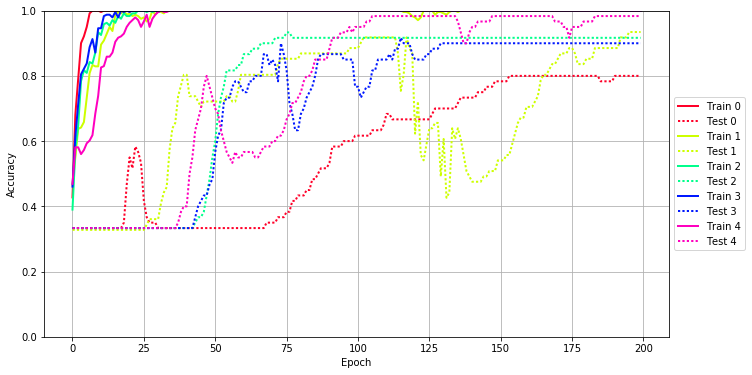

In [15]:
plot_acc(history)

In [16]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

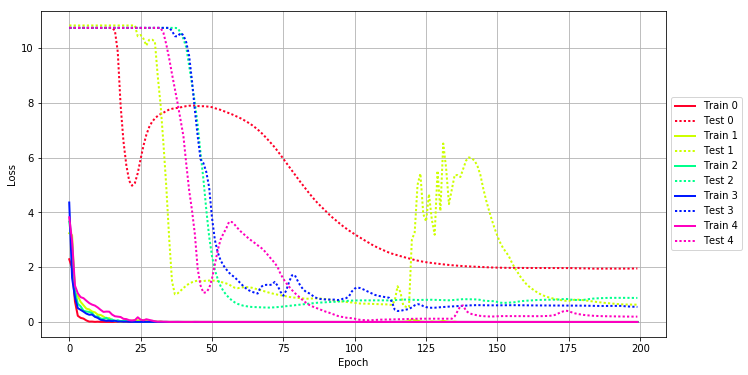

In [17]:
plot_loss(history)

Plotting the confusion matrix


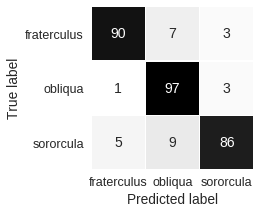

In [18]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(4, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


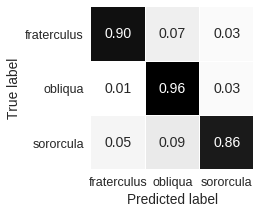

In [19]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(4, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [20]:
for h in history:
    print(h.history)

{'acc': [0.42738588519116161, 0.68049792679513643, 0.79253111785872843, 0.90041492341464979, 0.92116180742429998, 0.95020745873945878, 0.99170124679185545, 1.0, 1.0, 1.0, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [21]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

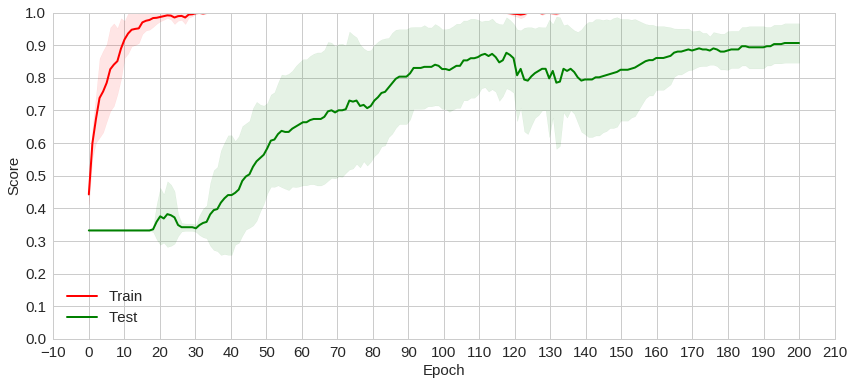

In [22]:
plot_mean_acc(history)

In [23]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

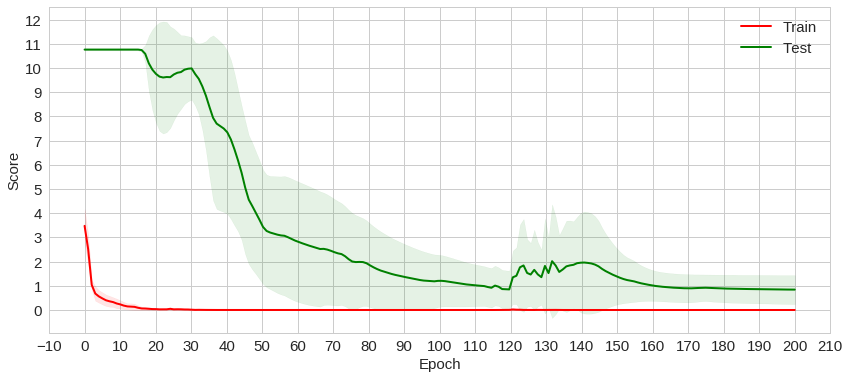

In [24]:
plot_mean_loss(history)

In [26]:
hist = [{'acc': [0.42738588519116161, 0.68049792679513643, 0.79253111785872843, 0.90041492341464979, 0.92116180742429998, 0.95020745873945878, 0.99170124679185545, 1.0, 1.0, 1.0, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [2.2914921920823854, 1.9713812801847814, 0.75266369200346384, 0.22571030902170047, 0.15038643060136139, 0.12328871750732676, 0.055520865200589804, 0.013480366451117012, 0.014885929432461866, 0.0039269089644689776, 0.0099703459981133336, 0.0025931413486383515, 0.00076560668852102953, 0.00048838247819436539, 0.00091542868538763513, 0.00066821441499717322, 0.00060403156862304361, 4.9587785396401294e-05, 0.00093553002330298721, 9.9428458111766428e-05, 0.00020831944824281415, 0.00013676622724708814, 0.00018164877952714123, 8.6468063088141657e-05, 0.00012262234296669017, 4.7693431457838904e-05, 4.9383735920146062e-05, 0.00010525020735556428, 9.1869367324723953e-05, 5.1593550413154276e-05, 6.6596167846785716e-05, 3.5625901157449435e-05, 2.4458621032014336e-05, 2.0184633225298929e-05, 0.00033400382100913869, 3.2195285957377148e-05, 1.8113082460406973e-05, 1.7845523671060606e-05, 0.00015660726800522306, 1.0848387390831863e-05, 0.00016067615317100927, 8.511642496401292e-06, 9.297198947522445e-06, 9.8980308997761688e-06, 2.5097848205050431e-05, 8.3219058137445976e-06, 5.4340036184843616e-06, 0.00014996038941464569, 6.0855952523604296e-05, 6.975043080232678e-06, 4.9888400416009719e-06, 6.315742082062034e-05, 7.4334851891898671e-06, 1.8848027512638858e-05, 5.988311374996435e-06, 2.9415333807279783e-05, 6.1745339361743043e-06, 7.580914478473698e-06, 9.3060955114800797e-06, 9.1450617221266549e-06, 1.7854542416762909e-05, 2.9182895661536528e-05, 1.7866361530616501e-05, 1.6847866168233597e-05, 2.1077545842298798e-05, 4.855741930162318e-06, 4.7350461790758411e-06, 7.1647097242496624e-06, 7.7360065266754693e-06, 8.8812641962358912e-06, 1.0025592724499448e-05, 1.7485971938076245e-05, 4.3316527634604999e-06, 1.4390034749449416e-05, 6.5729057617118162e-06, 4.2067455679102281e-06, 2.2852706794285978e-06, 2.9604713718940144e-06, 3.8733668555010443e-06, 1.0876892059576188e-05, 6.8820363349268931e-06, 3.3653452288316775e-06, 4.1046287434440564e-06, 3.1073950670349906e-06, 2.7631054146310601e-06, 1.3560261590651688e-05, 2.3632735438503353e-05, 3.0967490768100664e-06, 5.2447985128378323e-06, 6.195307795229586e-06, 2.9387074769090539e-06, 9.3927495042230448e-06, 3.7783861481779039e-06, 2.958995653528619e-06, 4.0484593328036231e-06, 9.6531939901473361e-06, 6.7278412334190799e-06, 1.421474448440952e-05, 7.8941964798803046e-06, 2.5291346948385782e-06, 6.8251984541717901e-06, 4.589675653699174e-06, 4.6097073801731566e-06, 5.1337200870517158e-06, 2.4099217446659679e-06, 2.7267498187418265e-06, 2.3552844421002452e-05, 8.8733660914119777e-06, 7.0687193853485482e-06, 2.9340126180855406e-06, 3.9500570715044212e-06, 3.0650963214094678e-06, 4.7482208702524864e-06, 2.9233822873969858e-06, 8.6878814733846778e-06, 2.0780121907501246e-06, 2.5002046127778748e-06, 1.8141189556373467e-06, 1.8576464304918833e-06, 2.7665784475167767e-06, 1.5869894931073536e-05, 2.9879320124236078e-06, 1.3906778415379547e-05, 1.8855942790307751e-06, 2.0542742611014471e-06, 2.379761584229546e-06, 4.4046538802616382e-06, 2.2335801914925309e-06, 1.893507903759091e-06, 2.3273217490794167e-06, 1.9476832680219901e-06, 3.1729423105664775e-06, 2.4166029852041968e-06, 3.9287591529221525e-06, 2.4967419909648076e-06, 2.4677985146133563e-06, 3.431881469544226e-06, 1.8796603237764528e-06, 1.5309304045516291e-06, 2.1712541781813661e-06, 2.3382162813746219e-06, 7.5403221222790364e-06, 4.1763561015938508e-06, 3.6809734105100154e-06, 2.2914564727280359e-06, 2.9105334028846071e-06, 6.6115468951435836e-06, 2.5909739426228254e-06, 1.2625834670508684e-06, 2.6819898455386357e-06, 1.2625837800434693e-06, 1.1997632695569623e-06, 1.8217901547415968e-06, 1.0899514420383322e-06, 3.6530107482459581e-06, 1.8299453663587192e-06, 3.2367505851328273e-06, 1.4082569930875983e-06, 1.8856010691068837e-06, 2.9312946044908028e-06, 2.1650815456665155e-06, 3.1620449677062139e-06, 5.5001729979040684e-06, 3.5187066425871866e-06, 1.3375229357081623e-06, 2.7846260037444894e-06, 5.1729027641969982e-06, 1.6674532409328305e-06, 1.6170023966339285e-06, 1.7629200443985624e-06, 2.4700375660325021e-06, 2.8798438476592291e-06, 5.0509660774059364e-06, 1.2150980177262621e-06, 9.9794696178081975e-07, 1.2194341327801842e-05, 7.8612758209363708e-06, 1.381550585947442e-06, 2.9434574762075105e-06, 4.017075851046518e-06, 1.9291289968218528e-06, 3.3700616957020321e-06, 2.4787571891167498e-05, 2.3829723439392872e-06, 9.6901108688041826e-07, 4.2705795979702117e-06, 6.4353874550757478e-06, 1.013566999663227e-05, 1.3672041717073621e-06, 4.5098130560207857e-06, 2.4146505878345569e-06, 1.2660468023549813e-06, 1.3691833560074445e-06, 4.5038520164104974e-06, 1.3518717180309199e-06, 4.206199419172191e-06, 6.0179016115221183e-06, 1.6578118979907449e-06, 1.0075940329356458e-06, 1.3966323308994718e-06], 'val_acc': [0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.3500000536441803, 0.46666669845581055, 0.55000007152557373, 0.5166667103767395, 0.58333337306976318, 0.56666672229766846, 0.533333420753479, 0.41666671633720398, 0.36666670441627502, 0.3500000536441803, 0.3500000536441803, 0.3500000536441803, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.3500000536441803, 0.3500000536441803, 0.3500000536441803, 0.3500000536441803, 0.36666670441627502, 0.36666670441627502, 0.36666670441627502, 0.38333335518836975, 0.38333335518836975, 0.41666671633720398, 0.41666671633720398, 0.43333339691162109, 0.43333339691162109, 0.43333339691162109, 0.45000004768371582, 0.45000004768371582, 0.48333340883255005, 0.48333340883255005, 0.50000005960464478, 0.5166667103767395, 0.5166667103767395, 0.5166667103767395, 0.533333420753479, 0.58333337306976318, 0.58333337306976318, 0.58333337306976318, 0.58333337306976318, 0.60000002384185791, 0.60000002384185791, 0.60000002384185791, 0.60000002384185791, 0.61666667461395264, 0.61666667461395264, 0.61666667461395264, 0.61666667461395264, 0.61666667461395264, 0.61666667461395264, 0.63333338499069214, 0.63333338499069214, 0.63333338499069214, 0.63333338499069214, 0.65000003576278687, 0.68333339691162109, 0.68333339691162109, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.66666674613952637, 0.68333339691162109, 0.70000004768371582, 0.70000004768371582, 0.70000004768371582, 0.70000004768371582, 0.70000004768371582, 0.70000004768371582, 0.70000004768371582, 0.70000004768371582, 0.71666669845581055, 0.73333334922790527, 0.73333334922790527, 0.73333334922790527, 0.73333334922790527, 0.73333334922790527, 0.73333334922790527, 0.75000005960464478, 0.75000005960464478, 0.75000005960464478, 0.76666676998138428, 0.76666676998138428, 0.76666676998138428, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373], 'val_loss': [10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.646119117736816, 9.8666276931762695, 7.9069957733154297, 6.5956583023071289, 5.7260046005249023, 5.1580629348754883, 4.9787302017211914, 5.0774416923522949, 5.4385099411010742, 5.9531345367431641, 6.4398174285888672, 6.8342242240905762, 7.1214632987976074, 7.3107786178588867, 7.4370489120483398, 7.530677318572998, 7.5980615615844727, 7.6444945335388184, 7.7109541893005371, 7.7584505081176758, 7.7898778915405273, 7.8061947822570801, 7.8228497505187988, 7.8413496017456055, 7.8649945259094238, 7.8870139122009277, 7.9006175994873047, 7.9063639640808105, 7.9028234481811523, 7.8926653861999512, 7.8789429664611816, 7.8830165863037109, 7.875889778137207, 7.8640341758728027, 7.8479495048522949, 7.810694694519043, 7.780022144317627, 7.7500400543212891, 7.7101354598999023, 7.6714911460876465, 7.6314420700073242, 7.5867676734924316, 7.540771484375, 7.4922595024108887, 7.4429636001586914, 7.3871326446533203, 7.326573371887207, 7.2651262283325195, 7.1944241523742676, 7.116607666015625, 7.0319328308105469, 6.9398813247680664, 6.8382391929626465, 6.7279982566833496, 6.6119694709777832, 6.4957222938537598, 6.379173755645752, 6.2442798614501953, 6.1030454635620117, 5.9620351791381836, 5.8202428817749023, 5.677426815032959, 5.5326061248779297, 5.3904032707214355, 5.2474856376647949, 5.1096830368041992, 4.9738740921020508, 4.8399052619934082, 4.7078561782836914, 4.5830478668212891, 4.4591612815856934, 4.3447117805480957, 4.2412500381469727, 4.1338157653808594, 4.0310444831848145, 3.9316661357879639, 3.8349406719207764, 3.7463974952697754, 3.6567645072937012, 3.5730412006378174, 3.4905910491943359, 3.4153358936309814, 3.3402340412139893, 3.2713062763214111, 3.206395149230957, 3.1375038623809814, 3.0735719203948975, 3.0126063823699951, 2.9492461681365967, 2.8898975849151611, 2.8257548809051514, 2.769608736038208, 2.7171854972839355, 2.6696019172668457, 2.6213934421539307, 2.5781564712524414, 2.5352070331573486, 2.4975986480712891, 2.4664111137390137, 2.435793399810791, 2.4058027267456055, 2.3760290145874023, 2.347740650177002, 2.3203928470611572, 2.2948157787322998, 2.2652595043182373, 2.2410874366760254, 2.2194302082061768, 2.2007443904876709, 2.1832156181335449, 2.1678586006164551, 2.1553361415863037, 2.1423141956329346, 2.1309635639190674, 2.1176347732543945, 2.1043334007263184, 2.0936896800994873, 2.0825648307800293, 2.0734777450561523, 2.0647993087768555, 2.0553667545318604, 2.0473580360412598, 2.0403413772583008, 2.0357720851898193, 2.0303084850311279, 2.0271248817443848, 2.0204110145568848, 2.0160157680511475, 2.0107011795043945, 2.0053222179412842, 1.9992655515670776, 1.995305061340332, 1.9908764362335205, 1.9874435663223267, 1.9837628602981567, 1.9817814826965332, 1.9792200326919556, 1.9777637720108032, 1.9768097400665283, 1.9765675067901611, 1.9752527475357056, 1.9746743440628052, 1.9731773138046265, 1.9721351861953735, 1.9716441631317139, 1.969855785369873, 1.9713404178619385, 1.9717773199081421, 1.9716577529907227, 1.9723970890045166, 1.9724379777908325, 1.9722129106521606, 1.9715242385864258, 1.9714744091033936, 1.9706175327301025, 1.9717071056365967, 1.974087119102478, 1.9741286039352417, 1.9743316173553467, 1.974389910697937, 1.9686095714569092, 1.9626184701919556, 1.9604004621505737, 1.9592667818069458, 1.9579524993896484, 1.9587948322296143, 1.9576619863510132, 1.9492878913879395, 1.9476726055145264, 1.948157787322998, 1.9484230279922485, 1.9499528408050537, 1.9503414630889893, 1.9510115385055542, 1.9494806528091431, 1.9495666027069092, 1.9500613212585449, 1.9492964744567871, 1.9494669437408447, 1.9489649534225464, 1.9507499933242798, 1.9529026746749878, 1.9541720151901245, 1.956025242805481]},
{'acc': [0.46666667064030964, 0.55000000397364301, 0.63749999999999996, 0.64166667461395266, 0.65833334128061927, 0.73333334922790527, 0.80833333730697632, 0.83333334525426228, 0.82916666666666672, 0.8291666825612386, 0.89583334128061931, 0.9083333373069763, 0.92916667461395264, 0.94999999999999996, 0.93750000397364297, 0.98750000000000004, 0.99583333730697632, 0.99166668256123858, 1.0, 0.98750000000000004, 0.99166667064030967, 0.98333334128061933, 0.98750000397364301, 0.98333334128061933, 0.97499999999999998, 0.9791666706403096, 0.96666667858759558, 0.97499999999999998, 1.0, 0.98750000000000004, 1.0, 0.99583333333333335, 0.9916666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99583334922790523, 0.99583334922790523, 0.9916666666666667, 0.98333334922790527, 0.97916667461395268, 0.97083333333333333, 0.97916667461395268, 1.0, 1.0, 1.0, 1.0, 0.98750001589457193, 0.99583334922790523, 0.99583333333333335, 0.9916666666666667, 0.98750000794728598, 0.99583333730697632, 1.0, 1.0, 0.99583333730697632, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [3.2420859972635907, 3.1737970829010012, 1.0601778626441956, 0.94699500004450476, 0.73381367524464924, 0.60751204093297317, 0.48673499027887979, 0.45955662926038104, 0.38386600017547606, 0.35200517177581786, 0.26646503806114197, 0.25650951464970906, 0.19728414714336395, 0.12910950283209482, 0.14376269951462745, 0.060590571413437523, 0.031366170197725293, 0.021784599746267001, 0.015367081761360169, 0.021991855154434841, 0.023247707138458886, 0.031142776211102802, 0.041705850015083951, 0.064696736137072247, 0.063341926038265231, 0.045423214137554166, 0.077523085474967959, 0.039032224317391714, 0.022882245481014252, 0.0420482753465573, 0.017491214722394944, 0.009955093745763104, 0.016222897668679556, 0.0028834187736113868, 0.0025785409690191347, 0.0022335865146790941, 0.00098196531956394519, 0.0014762967281664412, 0.0012294042855501175, 0.00065221453551203015, 0.00028537643568900722, 0.0003292165764529879, 0.00017700094419221085, 0.00025794134320070345, 0.00067148598609492185, 0.00024497197009623053, 0.00046428067920108634, 0.00021697263097545752, 0.00021638693870045244, 0.00014732392543616394, 0.00010480663622729481, 0.00021083543979329988, 0.00016599612135905772, 0.00017017470818245784, 0.00011390560151388247, 7.0185279764700684e-05, 0.00032311878749169409, 0.00017563812846977574, 7.1289636737977463e-05, 0.00054748870898038151, 7.348853687290102e-05, 0.0002192978368839249, 6.9826558319618923e-05, 6.3425480523922787e-05, 6.3633660223179803e-05, 0.00010547395165000732, 7.1011012672291454e-05, 5.998379274387844e-05, 9.2258329095784569e-05, 9.4600533824025967e-05, 5.8387054256551592e-05, 3.4905785044732812e-05, 6.3211370434146372e-05, 4.671309773887818e-05, 8.6545987384549033e-05, 0.00015865296203022202, 5.7453591822801778e-05, 7.911531453525337e-05, 6.2216557610857609e-05, 0.00011881984440454592, 5.9375523899992304e-05, 6.2678304675500837e-05, 3.4752132341964172e-05, 4.7428392281290141e-05, 0.00037141138357886424, 6.0109371164192754e-05, 0.00012214154994580895, 6.7537971578227973e-05, 5.1811892141510422e-05, 4.7889953323950368e-05, 5.6035140005405992e-05, 3.9596365483400101e-05, 4.6928652833836776e-05, 0.00058831326750805599, 4.5210247966072835e-05, 3.587645114748739e-05, 8.4220991023660951e-05, 9.5492706168442962e-05, 4.3766580347437412e-05, 0.00015159596708447983, 4.0070313843898475e-05, 7.6868475722828098e-05, 2.7443681574368384e-05, 0.00012809407780878246, 3.6790114730441319e-05, 3.9706280949758367e-05, 3.7167526655442393e-05, 8.2079025742132219e-05, 2.3386071067458639e-05, 2.0193323992619603e-05, 5.9285601795030135e-05, 0.00018380778007364522, 0.0014724761087563821, 5.7302994052103409e-05, 0.0015183634803785631, 4.0898980781397158e-05, 0.0097823127716158819, 0.0082172979057456054, 0.016884215207149587, 0.026915085191528004, 0.10658273932834467, 0.060862518226106964, 0.052265815871457261, 0.016207797639071941, 0.0092628012721737221, 0.0078291160520166155, 0.0037534679130961498, 0.020670973230153322, 0.010223826377963026, 0.0087646579757953685, 0.019391149445436896, 0.041454798448830842, 0.020049198095997176, 0.0083192878014718488, 0.0028138076110432544, 0.011895365826785565, 0.00043774747949404023, 0.0014488650422814922, 0.0014136197103653103, 9.3981794392069182e-05, 6.5776614307348305e-05, 0.00010894208001748969, 0.00021890287995726492, 0.00021248953707981856, 0.00046935479816359778, 6.2796214479021728e-05, 0.00032954253886903945, 0.00010378886751520137, 0.00011315516506632169, 8.1344112792673204e-05, 8.0896902848811195e-05, 8.4630879670536766e-05, 0.00022672031166924475, 0.00011633906930607433, 2.0430720420942332e-05, 7.9684979694623811e-05, 3.9093148613270995e-05, 1.9976503002302099e-05, 3.1586687994907456e-05, 5.5193854495882985e-05, 2.0325355277842996e-05, 9.0451971482252708e-05, 5.6477328568386537e-05, 3.8814498111605644e-05, 3.0940103897592053e-05, 8.0077810343937012e-05, 2.0343435729349342e-05, 2.9925974862029154e-05, 1.2531855706280718e-05, 1.7774853889325946e-05, 1.2683342780898481e-05, 1.4620506408391521e-05, 1.5548372781874303e-05, 2.9541114539218446e-05, 1.3507296110522778e-05, 0.00037069953141326549, 2.4654660713470851e-05, 3.0249363347441735e-05, 2.7038127154810353e-05, 1.9939495966051862e-05, 2.4276149148742357e-05, 3.0504368138887607e-05, 5.9989638733289517e-05, 2.7230631409717414e-05, 2.1612810087390244e-05, 1.8630494984487693e-05, 3.6068006860053474e-05, 3.4050119332581137e-05, 3.0323922328534535e-05, 2.6591401668459486e-05, 1.6928199086881554e-05, 4.9098411060792084e-05, 0.00013689034797910912, 6.2589321896666664e-05, 8.8141279168970257e-06, 1.9603606475963412e-05, 2.9212850010177741e-05, 2.1686932692925136e-05, 1.4672813085780944e-05, 6.5443865848161903e-05], 'val_acc': [0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.34426227211952209, 0.36065569519996643, 0.36065569519996643, 0.36065569519996643, 0.36065569519996643, 0.4098360538482666, 0.44262290000915527, 0.45901638269424438, 0.57377046346664429, 0.63934421539306641, 0.65573769807815552, 0.73770487308502197, 0.77049171924591064, 0.80327862501144409, 0.80327862501144409, 0.73770487308502197, 0.73770487308502197, 0.73770487308502197, 0.72131145000457764, 0.7049180269241333, 0.72131145000457764, 0.72131145000457764, 0.72131145000457764, 0.72131145000457764, 0.72131145000457764, 0.72131145000457764, 0.72131145000457764, 0.72131145000457764, 0.73770487308502197, 0.73770487308502197, 0.72131145000457764, 0.72131145000457764, 0.75409829616546631, 0.80327862501144409, 0.80327862501144409, 0.80327862501144409, 0.80327862501144409, 0.80327862501144409, 0.80327862501144409, 0.80327862501144409, 0.80327862501144409, 0.80327862501144409, 0.80327862501144409, 0.80327862501144409, 0.80327862501144409, 0.80327862501144409, 0.83606553077697754, 0.85245895385742188, 0.85245895385742188, 0.85245895385742188, 0.85245895385742188, 0.85245895385742188, 0.85245895385742188, 0.85245895385742188, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.90163934230804443, 0.91803276538848877, 0.91803276538848877, 0.91803276538848877, 0.91803276538848877, 0.91803276538848877, 0.91803276538848877, 0.91803276538848877, 0.91803276538848877, 0.91803276538848877, 0.91803276538848877, 0.91803276538848877, 0.91803276538848877, 0.86885237693786621, 0.75409829616546631, 0.80327868461608887, 0.91803276538848877, 0.88524585962295532, 0.86885243654251099, 0.62295079231262207, 0.72131145000457764, 0.55737704038619995, 0.54098355770111084, 0.59016388654708862, 0.63934421539306641, 0.63934421539306641, 0.65573763847351074, 0.65573763847351074, 0.49180322885513306, 0.60655730962753296, 0.42622947692871094, 0.44262292981147766, 0.63934421539306641, 0.60655736923217773, 0.63934421539306641, 0.60655736923217773, 0.55737698078155518, 0.50819671154022217, 0.49180322885513306, 0.47540980577468872, 0.47540980577468872, 0.47540980577468872, 0.47540980577468872, 0.49180322885513306, 0.49180322885513306, 0.50819671154022217, 0.50819671154022217, 0.50819671154022217, 0.54098355770111084, 0.54098355770111084, 0.54098355770111084, 0.55737698078155518, 0.55737698078155518, 0.59016388654708862, 0.62295079231262207, 0.65573763847351074, 0.67213112115859985, 0.67213112115859985, 0.7049180269241333, 0.7049180269241333, 0.7049180269241333, 0.72131145000457764, 0.73770487308502197, 0.78688520193099976, 0.80327868461608887, 0.80327868461608887, 0.8196721076965332, 0.83606553077697754, 0.83606553077697754, 0.85245895385742188, 0.86885243654251099, 0.86885243654251099, 0.86885243654251099, 0.88524585962295532, 0.88524585962295532, 0.86885243654251099, 0.83606553077697754, 0.83606553077697754, 0.83606553077697754, 0.85245895385742188, 0.85245895385742188, 0.85245895385742188, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.91803276538848877, 0.91803276538848877, 0.91803276538848877, 0.93442618846893311, 0.93442618846893311, 0.93442618846893311, 0.93442618846893311, 0.93442618846893311], 'val_loss': [10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.438996315002441, 10.485487937927246, 10.352398872375488, 10.099920272827148, 10.308422088623047, 10.314298629760742, 10.251893997192383, 8.9842872619628906, 7.9305601119995117, 6.5116205215454102, 4.9410314559936523, 3.0607914924621582, 1.4856629371643066, 1.012768030166626, 1.0462042093276978, 1.1419086456298828, 1.2396557331085205, 1.3331992626190186, 1.4004476070404053, 1.4506906270980835, 1.4868228435516357, 1.5117441415786743, 1.4906799793243408, 1.4950308799743652, 1.5110981464385986, 1.5133543014526367, 1.5123140811920166, 1.5099949836730957, 1.4930975437164307, 1.4673919677734375, 1.4370827674865723, 1.4075248241424561, 1.3673405647277832, 1.3018251657485962, 1.2499302625656128, 1.2342250347137451, 1.2520126104354858, 1.2693674564361572, 1.2741276025772095, 1.2659263610839844, 1.2505652904510498, 1.2212858200073242, 1.1944949626922607, 1.166231632232666, 1.1361979246139526, 1.1026904582977295, 1.0704377889633179, 1.0430011749267578, 1.0191528797149658, 0.99780642986297607, 0.97826999425888062, 0.95491969585418701, 0.93478143215179443, 0.91602230072021484, 0.89977538585662842, 0.88865870237350464, 0.87856584787368774, 0.86887848377227783, 0.85926985740661621, 0.84837687015533447, 0.85095763206481934, 0.85796815156936646, 0.86231327056884766, 0.86197358369827271, 0.85494780540466309, 0.84610211849212646, 0.83309781551361084, 0.8188709020614624, 0.80415058135986328, 0.77368688583374023, 0.76261997222900391, 0.75198334455490112, 0.74069690704345703, 0.73215711116790771, 0.72298121452331543, 0.71157044172286987, 0.69652378559112549, 0.68438929319381714, 0.6736147403717041, 0.66860151290893555, 0.67071497440338135, 0.66757762432098389, 0.66094106435775757, 0.65599215030670166, 0.65316104888916016, 0.64947295188903809, 0.64479678869247437, 0.64401572942733765, 0.63816046714782715, 0.61935609579086304, 0.77680975198745728, 1.3047300577163696, 1.0912038087844849, 0.59977972507476807, 0.55250805616378784, 0.53654032945632935, 3.0007040500640869, 3.2761623859405518, 5.0114073753356934, 5.4224758148193359, 3.9480078220367432, 3.6748483180999756, 4.6716156005859375, 3.7434947490692139, 3.1889729499816895, 5.5244174003601074, 4.0566940307617188, 6.5204744338989258, 5.6291241645812988, 4.3076300621032715, 4.82830810546875, 5.3660926818847656, 5.3663473129272461, 5.2958297729492188, 5.5998134613037109, 5.8988542556762695, 6.013453483581543, 5.9760446548461914, 5.8935699462890625, 5.6937041282653809, 5.3764858245849609, 4.8827075958251953, 4.4560403823852539, 4.0862884521484375, 3.735072135925293, 3.4182782173156738, 3.1354994773864746, 2.8884854316711426, 2.6915876865386963, 2.5510578155517578, 2.3988325595855713, 2.1764280796051025, 1.9843803644180298, 1.8178308010101318, 1.6589066982269287, 1.5232123136520386, 1.3969883918762207, 1.2998626232147217, 1.2174955606460571, 1.1469285488128662, 1.0748220682144165, 1.0170533657073975, 0.96932780742645264, 0.93011391162872314, 0.89662426710128784, 0.86905789375305176, 0.8432546854019165, 0.82165372371673584, 0.80329114198684692, 0.78745681047439575, 0.77330607175827026, 0.77031975984573364, 0.7969205379486084, 0.81236612796783447, 0.81608253717422485, 0.81117504835128784, 0.79975259304046631, 0.78509891033172607, 0.769508957862854, 0.75435757637023926, 0.74033421277999878, 0.72752773761749268, 0.71489399671554565, 0.70310062170028687, 0.69253987073898315, 0.68324494361877441, 0.67497044801712036, 0.66784727573394775, 0.65872913599014282, 0.64687305688858032, 0.64113575220108032, 0.63792824745178223, 0.63563543558120728, 0.63429474830627441, 0.63317561149597168, 0.63231033086776733]},
{'acc': [0.390041488705829, 0.57261411134632789, 0.64730290802682589, 0.78423235673627423, 0.81742737748316219, 0.80912861636070788, 0.84232365293621525, 0.83817426940712192, 0.87136929237990957, 0.93360994218296034, 0.92531118699623838, 0.95850620774312634, 0.96265558335790991, 0.95435683806407501, 0.97095434868484121, 0.96265559349811913, 0.98340248962655596, 0.97510371811657026, 0.99170124679185545, 0.98340248962655596, 0.98340248962655596, 0.9917012346730687, 0.99170124679185545, 1.0, 1.0, 1.0, 0.99585062240663902, 1.0, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [3.6664662875575149, 2.8698353470608406, 1.1337262157087999, 0.66858496730258354, 0.57017724246899615, 0.40889041045394675, 0.38178977926737045, 0.36743057380078742, 0.32748888661752595, 0.19976842020062491, 0.2042640910109049, 0.12493902852921071, 0.11249024071634063, 0.15330500078399151, 0.079872865368963777, 0.092938908402850517, 0.029396657990407648, 0.063884166266413647, 0.027194184046315947, 0.045215424907652672, 0.038057713750054234, 0.032448703817312151, 0.027726680380427492, 0.0029751369613705827, 0.0049344341858015761, 0.0029167917202501193, 0.0072425392483403571, 0.0023325518545543938, 0.0083641092528693416, 0.0023825023411695855, 0.0048090587428063769, 0.00045155914074304626, 0.00038645731737350279, 0.0009758405820215391, 0.00096301102471688604, 0.00020945816410945041, 0.00038126021424594387, 0.0004527868680787346, 0.00026524763339859939, 0.00027469062424869626, 0.00024203602002384876, 0.00016297007083923738, 0.00029473427016021397, 0.00072408109665795183, 0.00025686237833528352, 0.00017642153648483758, 0.00030044369236276294, 0.00036281544939301813, 0.00064537158048483712, 0.00021379862448753193, 0.00012652788741641612, 5.1170156024062146e-05, 5.3064921054229744e-05, 7.113402148301006e-05, 0.00010105580116927197, 8.4510884274650346e-05, 0.00022019497214292882, 0.00011218516369827509, 4.3679220105641659e-05, 0.00014292096771798349, 0.00011005434275245394, 0.00015027980247456425, 6.2484439212202842e-05, 4.4430687672630557e-05, 7.8908551654138857e-05, 0.00014125092302379489, 0.00027314064441817811, 0.00012958890876379656, 0.00018636160010869975, 7.3291353421977475e-05, 5.6569865316392169e-05, 4.6758091656447204e-05, 3.6967866605411462e-05, 5.2263949615146612e-05, 7.9182321454506543e-05, 5.4678723622544346e-05, 3.596023419491282e-05, 2.9114435519697047e-05, 5.2426287852936808e-05, 4.2439437104452837e-05, 6.9147794042748715e-05, 4.2819437516285148e-05, 3.9799089421067945e-05, 4.4362379533395217e-05, 5.3053756504845165e-05, 4.1759181606483789e-05, 0.0001275522533670856, 3.8150568971897312e-05, 5.1661536825243077e-05, 4.0090677739725802e-05, 6.5966438515598723e-05, 2.9046569538292575e-05, 3.1471405583709146e-05, 2.0194746462963483e-05, 9.3813199873316131e-05, 0.00013655065854115768, 0.00017775786465820778, 4.0266991937298742e-05, 2.2434249738701309e-05, 2.1322805716023834e-05, 6.7305098799433119e-05, 6.8427118169881894e-05, 2.6278023836753597e-05, 2.3513657108641951e-05, 2.4342782865713169e-05, 3.2693031742126404e-05, 2.9982037967142429e-05, 7.647621692679977e-05, 5.4632111279406447e-05, 9.2243753595584892e-05, 4.260614683418786e-05, 4.4496422726817955e-05, 5.4945203034145394e-05, 3.8232753539740022e-05, 3.0317400522417527e-05, 0.00016035201620693122, 2.803277139526819e-05, 3.3210863109776571e-05, 3.6069323291617574e-05, 3.4869759678318943e-05, 1.1422509764978944e-05, 2.6119677759914687e-05, 3.7023804665695784e-05, 3.3888752940323403e-05, 3.3864520540859704e-05, 2.099882384154852e-05, 6.9896330100752772e-05, 6.70913195262153e-05, 3.3432668322770709e-05, 1.576202581018302e-05, 5.0329779613742804e-05, 3.4578295322656785e-05, 0.00010584939737174819, 0.00012628136215252315, 5.9360891741920744e-05, 0.00010364496533631413, 2.1807861808024219e-05, 2.954786990005262e-05, 8.1517490658800874e-05, 2.1871388956268717e-05, 1.8254348890941892e-05, 6.7475181690289699e-05, 1.3793662929022492e-05, 1.6003439668565989e-05, 0.00017281416092909433, 1.1986741863521535e-05, 0.00012370619181815547, 2.2645294599115987e-05, 1.3969213215201172e-05, 1.7571883385002767e-05, 0.00044089871801464205, 1.3206684226469674e-05, 4.8634319335412567e-05, 9.0366784531257933e-05, 2.5724538269112682e-05, 2.1672503402238302e-05, 3.8630502925595437e-05, 7.7023245157534841e-05, 3.2372234574677541e-05, 3.812523444977307e-05, 1.5012464279920458e-05, 2.1256150524914498e-05, 2.2654468155157111e-05, 0.00010867642636770282, 7.264121527120826e-05, 1.5691529826721934e-05, 3.6466099752119989e-05, 1.9441495569330095e-05, 2.9761635217621452e-05, 2.2882409109994846e-05, 1.5423227242419097e-05, 1.9622396314719546e-05, 0.00012162488762830786, 9.7096863648093633e-06, 1.9651486015930787e-05, 0.00032013714812498896, 2.0699202046761987e-05, 0.00016098384059124135, 1.6614443020859137e-05, 2.1567627183111922e-05, 4.6526904760304879e-05, 0.00010183114784043204, 2.1000762329498669e-05, 1.1511324015199651e-05, 3.8825197029893609e-05, 4.1940722892764198e-05, 2.4598041054333443e-05, 2.1096864385294623e-05, 6.5814608617331178e-05, 1.1573245380732185e-05, 7.205161376707971e-06, 1.4131698236379027e-05, 4.2942011634325532e-05, 2.15460750192483e-05, 3.3367520756874601e-05, 6.6810310355582541e-06, 1.2282143667047067e-05, 1.7199296362604365e-05, 3.7591538716979994e-05, 1.8968213878763274e-05], 'val_acc': [0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.3500000536441803, 0.36666670441627502, 0.36666670441627502, 0.38333338499069214, 0.43333336710929871, 0.48333340883255005, 0.55000007152557373, 0.60000002384185791, 0.68333339691162109, 0.73333334922790527, 0.76666676998138428, 0.81666672229766846, 0.81666672229766846, 0.81666672229766846, 0.81666672229766846, 0.83333343267440796, 0.83333343267440796, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.93333339691162109, 0.93333339691162109, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637], 'val_loss': [10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.732980728149414, 10.570847511291504, 10.342986106872559, 10.031496047973633, 9.3565664291381836, 8.6612443923950195, 8.0121288299560547, 7.1904964447021484, 6.1607227325439453, 5.21527099609375, 4.1114416122436523, 3.1272215843200684, 2.4087851047515869, 1.9041720628738403, 1.5711696147918701, 1.3156893253326416, 1.128425121307373, 0.99277836084365845, 0.87988924980163574, 0.78632611036300659, 0.71410143375396729, 0.66210883855819702, 0.62327814102172852, 0.59454989433288574, 0.57470214366912842, 0.55879288911819458, 0.54893863201141357, 0.5437127947807312, 0.5367966890335083, 0.53472024202346802, 0.53090506792068481, 0.52679747343063354, 0.52561020851135254, 0.52853929996490479, 0.53436028957366943, 0.54264509677886963, 0.5538983941078186, 0.56561964750289917, 0.57713961601257324, 0.58866685628890991, 0.59932273626327515, 0.61012101173400879, 0.62227261066436768, 0.6370854377746582, 0.64929801225662231, 0.66182941198348999, 0.67395925521850586, 0.68611186742782593, 0.69531768560409546, 0.70345145463943481, 0.71019220352172852, 0.71553486585617065, 0.72140347957611084, 0.72817343473434448, 0.73347049951553345, 0.73771971464157104, 0.74640077352523804, 0.75365501642227173, 0.76073306798934937, 0.76839977502822876, 0.77545183897018433, 0.78046137094497681, 0.78483492136001587, 0.78832805156707764, 0.78868907690048218, 0.79123294353485107, 0.79289186000823975, 0.79306328296661377, 0.79141533374786377, 0.79076087474822998, 0.79304331541061401, 0.79149752855300903, 0.79038572311401367, 0.78755801916122437, 0.78730714321136475, 0.79235392808914185, 0.79938513040542603, 0.80421781539916992, 0.81236153841018677, 0.81667011976242065, 0.8186461329460144, 0.81432664394378662, 0.80860435962677002, 0.80544644594192505, 0.8043028712272644, 0.8058476448059082, 0.8089674711227417, 0.80936700105667114, 0.81158208847045898, 0.81188911199569702, 0.80884617567062378, 0.80484676361083984, 0.8019900918006897, 0.79925400018692017, 0.79332786798477173, 0.79185903072357178, 0.79711276292800903, 0.80698388814926147, 0.81940174102783203, 0.82795965671539307, 0.83345204591751099, 0.83198213577270508, 0.83042997121810913, 0.82950711250305176, 0.82614237070083618, 0.82322335243225098, 0.80631905794143677, 0.78331553936004639, 0.7711605429649353, 0.76484912633895874, 0.76168650388717651, 0.76025736331939697, 0.72929674386978149, 0.70625060796737671, 0.69573968648910522, 0.69996482133865356, 0.7068297266960144, 0.71314531564712524, 0.72105151414871216, 0.73968595266342163, 0.75765144824981689, 0.76735603809356689, 0.77580618858337402, 0.78134399652481079, 0.78739261627197266, 0.7951083779335022, 0.80395883321762085, 0.80776309967041016, 0.80951380729675293, 0.81160533428192139, 0.81264549493789673, 0.81350219249725342, 0.81576383113861084, 0.81657713651657104, 0.82807159423828125, 0.83561444282531738, 0.84093540906906128, 0.83416330814361572, 0.81280165910720825, 0.80469799041748047, 0.80168229341506958, 0.80183053016662598, 0.80618941783905029, 0.81730091571807861, 0.83594870567321777, 0.8488609790802002, 0.85973906517028809, 0.86584210395812988, 0.86904168128967285, 0.87356376647949219, 0.8787035346031189, 0.88115614652633667, 0.88168460130691528, 0.8821447491645813, 0.8814244270324707, 0.88112556934356689, 0.8814806342124939, 0.88105630874633789, 0.87999504804611206, 0.8794437050819397, 0.87845629453659058, 0.878132164478302]},
{'acc': [0.46058091187378181, 0.61410787491382901, 0.71369294160629204, 0.80497924866023396, 0.82157676694798765, 0.83817426544996709, 0.88796679261314426, 0.91286305619473285, 0.87136928223970023, 0.94605807694162081, 0.94605807298446587, 0.98340249160513349, 0.98755186721991706, 0.98755185707970772, 0.97925310189298576, 0.99585062240663902, 0.97925310189298576, 1.0, 0.99585062240663902, 1.0, 0.99585061226642968, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [4.364720427643709, 1.6113176177646114, 0.90943911214092465, 0.50793671570872867, 0.44423117924528005, 0.37745970190807993, 0.30531464102851902, 0.26475481348908292, 0.27006121901061031, 0.18924912278582942, 0.14878936328333939, 0.078160909201594311, 0.06387075212981197, 0.041905375514411335, 0.048572992048075588, 0.029811863335336392, 0.048388475188946824, 0.016096897013640008, 0.017972966265783517, 0.010117340481287464, 0.013310214697820023, 0.0058879385261769368, 0.006243639523202082, 0.0051890286178370602, 0.0017799077820249243, 0.0024562271879947284, 0.0070203149070986451, 0.0011978571137019212, 0.0011967583554622976, 0.0026324095351320086, 0.0055286414905343032, 0.00086478742479087782, 0.0046641378203615604, 0.001467408296092765, 0.0042045995365070851, 0.0010552954119997277, 0.0026842414952632952, 0.0015471989831875592, 0.0037299187166067575, 0.0013259408553034314, 0.0011197009118548227, 0.0018863156404060261, 0.00075066507131216805, 0.00069165774848103457, 0.00040420383773840719, 0.00091533749886011685, 0.0015750867179382391, 0.00045314818814868316, 0.00023798390801974738, 0.00028377959743350806, 0.0012639766352258901, 0.00038184456844114664, 0.00033130183074110345, 0.00020809103191660666, 0.00029486482245635041, 0.00027777262551795029, 0.00015270631592257018, 0.00025200828788145079, 0.00029204124092081893, 0.00017366657544147702, 0.00054262590901810225, 0.00015175154749535921, 7.0594272983726114e-05, 0.00012406611504010021, 7.3564049309115712e-05, 0.00013009076129828184, 0.0015966398583500958, 0.00016956142496696338, 0.00013035226170566799, 0.0004324252152087503, 0.00021124197640147107, 0.0024286829769858682, 0.00076809350625298828, 0.0013498736504867241, 0.00051072318709737528, 0.00035991699191359071, 0.00063471284830707026, 0.0002452579298971078, 0.00015023385084724959, 0.0014183664099309454, 0.00024529141219356001, 0.00018976238761865243, 6.6291637592118119e-05, 0.00010073452833986791, 0.00027971324308956991, 0.00041424215254272405, 0.00028180194155436733, 4.0433341001437717e-05, 9.81277683788439e-05, 7.5377919170759126e-05, 0.00023393130149205381, 7.3253158267386472e-05, 0.00011657747629396154, 8.0563210233991885e-05, 0.0012365776593352502, 8.2647089509021001e-05, 0.00029632640044343527, 0.00037091037382166911, 0.0018079420568564465, 5.6374780529398953e-05, 8.5061798304516463e-05, 0.00023655181062790369, 8.9110855915954654e-05, 0.00010888428755512237, 7.5531535482669781e-05, 0.00013022272593024887, 0.00010977457940464461, 5.8904461652239498e-05, 0.00043351395034880465, 9.861467355282357e-05, 3.9092573369319428e-05, 0.00013129894929132289, 3.5935415677060624e-05, 0.0022825964521693987, 0.00032173035266863268, 0.001635563297171138, 0.00037768956787519051, 0.0002645268622438976, 0.00076059160099067262, 0.00033612456396115841, 0.00067618701759633061, 0.00019179069687307067, 0.00012949294837783922, 0.00037643637245374104, 0.00016271985545720618, 5.1002587787936207e-05, 6.0861383859914462e-05, 7.3458942818007124e-05, 0.00010673657621337194, 0.00013273463490770751, 3.5320775791339929e-05, 8.0801165838778041e-05, 4.1438553537120388e-05, 5.0469106156234066e-05, 7.2430259175212185e-05, 8.8866486931915293e-05, 6.1686972912866622e-05, 4.564788327855493e-05, 6.8242969162278142e-05, 2.5234955814447259e-05, 4.6611599103307076e-05, 8.6586506696368661e-05, 6.2024587218522154e-05, 3.9398223230834077e-05, 0.00014994360089721833, 2.9638704879564924e-05, 6.7676705262006382e-05, 2.6057042693888336e-05, 2.0881970260264275e-05, 6.0537983311054732e-05, 3.5419545421513043e-05, 2.5579304071708439e-05, 0.00011378600229137225, 5.0211194894205067e-05, 2.1314590714564662e-05, 2.0064421699003651e-05, 2.3567874480427256e-05, 2.5140937241190402e-05, 3.8989398939316683e-05, 2.349033927214303e-05, 2.4786851571363693e-05, 2.2851603837607474e-05, 4.7419432027041293e-05, 1.8584821957414215e-05, 1.8376843452725813e-05, 2.0764396808262823e-05, 5.1394241389333506e-05, 3.0178578187184045e-05, 2.2748307818352462e-05, 1.08983897301779e-05, 3.8694046686270131e-05, 4.8675465796536986e-05, 4.317707969532715e-05, 1.8318918780522725e-05, 1.6190846750360074e-05, 1.9132968142055771e-05, 1.6817899299007781e-05, 5.0208164684288976e-05, 1.9531744041748701e-05, 1.8468540878514798e-05, 2.004458606864458e-05, 6.1219294102141767e-05, 1.3694645606835868e-05, 5.0006575840288635e-05, 7.5841645702441447e-05, 1.669146966310392e-05, 4.7936691084772318e-05, 6.1232955780558254e-05, 1.8028188051213413e-05, 4.7464910868064526e-05, 2.9547170343899644e-05, 2.3220227731182143e-05, 1.4088950287169077e-05, 1.0277544509286652e-05, 0.00015847709808712129, 3.0779109492944359e-05, 1.6647823880348332e-05, 0.00010274217586724775, 3.3702687563227792e-05, 1.0287222257490209e-05], 'val_acc': [0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.36666670441627502, 0.40000003576278687, 0.41666668653488159, 0.43333336710929871, 0.43333336710929871, 0.46666669845581055, 0.48333337903022766, 0.56666672229766846, 0.61666667461395264, 0.63333332538604736, 0.71666669845581055, 0.73333340883255005, 0.73333340883255005, 0.7666667103767395, 0.783333420753479, 0.783333420753479, 0.76666676998138428, 0.75000005960464478, 0.75000005960464478, 0.783333420753479, 0.783333420753479, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.86666667461395264, 0.86666673421859741, 0.83333337306976318, 0.85000002384185791, 0.83333337306976318, 0.78333336114883423, 0.90000003576278687, 0.86666667461395264, 0.81666672229766846, 0.71666675806045532, 0.68333339691162109, 0.63333338499069214, 0.63333338499069214, 0.68333339691162109, 0.70000004768371582, 0.73333334922790527, 0.75000005960464478, 0.76666676998138428, 0.80000007152557373, 0.85000002384185791, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000002384185791, 0.7666667103767395, 0.7666667103767395, 0.73333334922790527, 0.75000005960464478, 0.7666667103767395, 0.7666667103767395, 0.81666672229766846, 0.81666672229766846, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.86666673421859741, 0.85000002384185791, 0.88333344459533691, 0.88333338499069214, 0.91666668653488159, 0.90000003576278687, 0.90000009536743164, 0.90000009536743164, 0.86666673421859741, 0.85000002384185791, 0.85000002384185791, 0.85000002384185791, 0.85000002384185791, 0.86666673421859741, 0.86666673421859741, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164], 'val_loss': [10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.637771606445312, 10.441684722900391, 10.433113098144531, 10.561107635498047, 10.477498054504395, 10.215854644775391, 9.7208547592163086, 8.8041744232177734, 7.7399516105651855, 6.7807579040527344, 5.9410820007324219, 5.802950382232666, 5.4835476875305176, 4.9239859580993652, 3.8134770393371582, 3.0030050277709961, 2.5506124496459961, 2.2558224201202393, 2.0683712959289551, 1.9242587089538574, 1.797666072845459, 1.7061618566513062, 1.6283090114593506, 1.5228567123413086, 1.4197701215744019, 1.3083090782165527, 1.2211458683013916, 1.1527330875396729, 1.1059684753417969, 1.0665987730026245, 1.0390429496765137, 1.265001654624939, 1.3409668207168579, 1.3570271730422974, 1.3502702713012695, 1.3642776012420654, 1.4665155410766602, 1.321847677230835, 1.1020704507827759, 0.95983731746673584, 1.1480555534362793, 1.4613399505615234, 1.7029467821121216, 1.7152278423309326, 1.5052361488342285, 1.3169131278991699, 1.1871018409729004, 1.0946329832077026, 1.0497347116470337, 0.97935879230499268, 0.90266293287277222, 0.86217981576919556, 0.8393176794052124, 0.82709723711013794, 0.82158946990966797, 0.81940180063247681, 0.81569266319274902, 0.81595158576965332, 0.80198812484741211, 0.81245577335357666, 0.85239982604980469, 0.8716660737991333, 0.93968605995178223, 1.1173052787780762, 1.2214710712432861, 1.2602274417877197, 1.2338885068893433, 1.1908568143844604, 1.1403641700744629, 1.0916455984115601, 1.0382840633392334, 0.99275738000869751, 0.96016228199005127, 0.9392552375793457, 0.92087304592132568, 0.9025464653968811, 0.88631224632263184, 0.74087893962860107, 0.45149677991867065, 0.4023706316947937, 0.40527600049972534, 0.43182715773582458, 0.45409613847732544, 0.47287231683731079, 0.53578269481658936, 0.60856163501739502, 0.64855343103408813, 0.63941735029220581, 0.5784955620765686, 0.54246777296066284, 0.52472293376922607, 0.5188249945640564, 0.52110600471496582, 0.52837663888931274, 0.53872781991958618, 0.54727637767791748, 0.55451059341430664, 0.56184393167495728, 0.56830251216888428, 0.5772365927696228, 0.58378708362579346, 0.59059286117553711, 0.5966949462890625, 0.60232144594192505, 0.60565865039825439, 0.61034953594207764, 0.6139681339263916, 0.6159062385559082, 0.61237335205078125, 0.61028140783309937, 0.60878121852874756, 0.60765820741653442, 0.60733968019485474, 0.60738301277160645, 0.60882556438446045, 0.60996836423873901, 0.61001980304718018, 0.61296051740646362, 0.61426937580108643, 0.61456656455993652, 0.61366027593612671, 0.61164659261703491, 0.60988885164260864, 0.60909140110015869, 0.60722088813781738, 0.60592502355575562, 0.60551363229751587, 0.60478359460830688, 0.60383760929107666, 0.60245943069458008, 0.60028994083404541, 0.6002579927444458, 0.60015624761581421, 0.59989488124847412, 0.59889805316925049, 0.5991816520690918, 0.59904223680496216, 0.59757828712463379, 0.59563291072845459, 0.59477609395980835, 0.59463858604431152, 0.59446007013320923, 0.59584987163543701, 0.59645974636077881, 0.59662926197052002, 0.59470087289810181, 0.59240353107452393, 0.58618646860122681, 0.58399176597595215, 0.58402389287948608, 0.5844959020614624, 0.58551180362701416, 0.58624756336212158, 0.58633476495742798, 0.58734965324401855, 0.58794569969177246, 0.58822226524353027, 0.58815270662307739, 0.58173930644989014, 0.57052409648895264, 0.56419867277145386, 0.5589677095413208, 0.55215626955032349, 0.54916179180145264]},
{'acc': [0.46887966508192641, 0.58091286628572769, 0.58091286628572769, 0.56016596817871345, 0.57261409700164156, 0.59336099486133365, 0.60165974435964564, 0.61825726264739922, 0.68464730240992, 0.73858919900482622, 0.82572613266988415, 0.82987550234893548, 0.8589211514381947, 0.85892115341677211, 0.87136928421827764, 0.90456430298658819, 0.91701243180951642, 0.92116181138145481, 0.92946056656817677, 0.95020746071803619, 0.96265560363832847, 0.97095435882505043, 0.97925309175277642, 0.97095434250178669, 0.95020745873945878, 0.96680495897269347, 0.98755186721991706, 0.95020746071803619, 0.97510371811657026, 0.98755185707970772, 0.99585062240663902, 1.0, 0.99585062240663902, 0.99585061226642968, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [3.8245038283811073, 2.9608968619983722, 1.332102443172724, 1.0459537703961257, 0.90681525904113325, 0.86987028873807659, 0.7763324424438951, 0.69069780947261827, 0.63396586323180137, 0.59856778061736171, 0.52835021770841351, 0.44210026063859709, 0.3672347024268629, 0.38018480672875876, 0.37602488269944406, 0.27100941118363026, 0.2090583625423463, 0.19634927289861862, 0.18116037893839396, 0.11543795531345107, 0.10516317794679111, 0.065900579434954767, 0.05597556298946444, 0.067731479638839659, 0.17203955412591146, 0.085126052011592748, 0.059375585315756776, 0.099842889845000268, 0.075185659762734697, 0.05238243047132532, 0.026361884765667046, 0.011619795368852952, 0.013268966803566797, 0.0085458248018971117, 0.0076566958544907237, 0.0025290789810121367, 0.003011369457491577, 0.001392320918182058, 0.0013464771788876458, 0.0014231218995054975, 0.0056597593151558488, 0.0014763241005806384, 0.0010555238430137086, 0.00099830655042947697, 0.004401628229442474, 0.0013883180618749862, 0.0019338528690395946, 0.0018772508087278154, 0.0010628910151723758, 0.00065501425482904641, 0.0011200910790135534, 0.00057467387451044447, 0.00039798080272918481, 0.00035314979823885867, 0.00033356167793397584, 0.0013658041939964417, 0.00018931285740109161, 0.00046273684107381617, 0.00036884431548018582, 0.00013045736632495345, 0.00022724457966700906, 0.00018646294616754032, 0.00021946892166206869, 0.00020811399216696049, 0.00026000036329805806, 0.00016419597532111316, 0.00021062062592419538, 0.00019940112796428526, 0.00014377306700931453, 0.00012684266261188352, 0.00011873731547961769, 0.00016551369465926192, 0.00012733125101525676, 0.00018447172524662558, 0.00036752246451516793, 0.00012568927231617659, 0.0001030268388630289, 0.00011828582193093814, 0.00010548255054779636, 7.4132958608698796e-05, 0.00012000571140300683, 8.7638314524993944e-05, 0.00024989987439434896, 8.2306785936973591e-05, 0.00010050948662393537, 0.00040279815642016312, 0.00010319019775766168, 5.7053241205616194e-05, 0.00013925005098286999, 0.00010296034325238827, 7.8283959541506522e-05, 0.00036424124597916446, 8.1860420096779621e-05, 8.6432835618536376e-05, 6.8333022648089904e-05, 0.00039068106813085771, 7.6255006621460359e-05, 0.00036288647723086641, 5.823818485385881e-05, 4.4150372921958704e-05, 0.00020959462508698346, 6.1640549435172055e-05, 6.5121698327057247e-05, 8.6823906596118184e-05, 5.115395279855301e-05, 0.00031185722857939767, 5.8260970103846193e-05, 5.9336879360924297e-05, 6.5304581212368703e-05, 7.9738979460430013e-05, 0.00011485481247812107, 4.0783687734771596e-05, 5.8044598491464384e-05, 4.1883252428253314e-05, 0.0001467862955045295, 0.00050566996328428354, 7.1238863586650525e-05, 0.00030415132303656506, 0.00014024275355101407, 5.8615601606352091e-05, 6.291744530735213e-05, 0.00016118435448043327, 5.9882833467095057e-05, 5.1752976592315197e-05, 8.787614058150573e-05, 0.00017543706300965977, 6.675025916400392e-05, 6.8164935830161282e-05, 0.00016139090496899861, 4.4555623925781784e-05, 4.9616340458133698e-05, 4.4955047695157e-05, 0.00030399375658915126, 4.5646398477507484e-05, 4.5502765413448096e-05, 0.00098319284836964529, 3.9539782835665272e-05, 4.2784217398114216e-05, 0.00073681590224604636, 8.6616084626412091e-05, 8.7457853386321596e-05, 6.9064070987254298e-05, 0.00013816151591655471, 0.0003534313151830251, 9.5719585453133058e-05, 6.6780782425104681e-05, 9.1946752556954474e-05, 0.00011346267580783624, 0.00019547549516920975, 0.00074834166621428016, 5.791051572558752e-05, 6.7384073839723849e-05, 7.5088108676491509e-05, 7.7039907704285222e-05, 7.3830945925937801e-05, 0.00011520384870884028, 4.9544815221029481e-05, 6.3079169104107626e-05, 3.002900245455258e-05, 5.0094683973540849e-05, 4.9448457382113627e-05, 6.6444559978440506e-05, 3.5664250926139739e-05, 3.9825075835784652e-05, 2.467329984455209e-05, 0.00104118361238282, 5.0353714434842528e-05, 4.4918076003405568e-05, 0.00012358498361775134, 0.00061647833308786605, 0.00041069206878295578, 0.0010174274217485666, 0.00010479334409733175, 0.00016881589508708179, 5.3366765363481959e-05, 0.00032020830940571133, 6.8576923585777019e-05, 8.7152630074048242e-05, 4.8157101246109037e-05, 6.0108535634682233e-05, 4.556174325409898e-05, 6.5631374810470647e-05, 3.7587090736908138e-05, 0.00015193992644583197, 6.4776166134124569e-05, 6.9161802827365145e-05, 5.1555422700803169e-05, 2.9400036472458144e-05, 5.1522710014238984e-05, 3.4949994802762871e-05, 2.3787694391024035e-05, 2.5299902298989854e-05, 0.00021894588558079024, 6.0709666648417849e-05, 4.224137983215331e-05, 2.8306333483650863e-05, 4.8015158951569436e-05, 6.0563031187620597e-05, 2.9795805212830994e-05, 2.4435717660930834e-05], 'val_acc': [0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.3500000536441803, 0.38333338499069214, 0.40000003576278687, 0.40000003576278687, 0.50000005960464478, 0.55000007152557373, 0.63333338499069214, 0.66666674613952637, 0.70000004768371582, 0.7666667103767395, 0.80000007152557373, 0.7666667103767395, 0.73333340883255005, 0.70000004768371582, 0.68333339691162109, 0.63333338499069214, 0.60000002384185791, 0.56666672229766846, 0.55000007152557373, 0.533333420753479, 0.56666672229766846, 0.55000007152557373, 0.55000007152557373, 0.56666672229766846, 0.56666672229766846, 0.56666672229766846, 0.56666672229766846, 0.55000007152557373, 0.55000007152557373, 0.56666672229766846, 0.58333337306976318, 0.58333337306976318, 0.58333337306976318, 0.60000002384185791, 0.60000002384185791, 0.61666673421859741, 0.61666673421859741, 0.63333338499069214, 0.66666674613952637, 0.68333339691162109, 0.71666669845581055, 0.71666669845581055, 0.73333340883255005, 0.75000011920928955, 0.783333420753479, 0.80000007152557373, 0.80000007152557373, 0.81666672229766846, 0.85000002384185791, 0.85000002384185791, 0.85000002384185791, 0.85000002384185791, 0.85000002384185791, 0.88333344459533691, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.95000004768371582, 0.93333339691162109, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.96666669845581055, 0.96666669845581055, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.96666669845581055, 0.93333333730697632, 0.90000003576278687, 0.90000003576278687, 0.93333333730697632, 0.95000004768371582, 0.95000004768371582, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.95000004768371582, 0.95000004768371582, 0.91666674613952637, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005, 0.98333340883255005], 'val_loss': [10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.561553001403809, 10.140464782714844, 9.6332740783691406, 9.0558195114135742, 8.5141048431396484, 7.9698185920715332, 7.3815603256225586, 6.7847995758056641, 5.7691211700439453, 4.8133907318115234, 4.0753889083862305, 3.2123775482177734, 1.9339194297790527, 1.3298430442810059, 1.0657117366790771, 1.0857661962509155, 1.2293083667755127, 1.5802502632141113, 2.1062617301940918, 2.612741231918335, 3.0092768669128418, 3.2309932708740234, 3.4182190895080566, 3.6639928817749023, 3.6509523391723633, 3.5492038726806641, 3.4264082908630371, 3.3147344589233398, 3.2233638763427734, 3.1304965019226074, 3.0362930297851562, 2.9614148139953613, 2.8837869167327881, 2.8018536567687988, 2.7291460037231445, 2.6381509304046631, 2.5227351188659668, 2.3919010162353516, 2.2753684520721436, 2.1520175933837891, 2.002300500869751, 1.7580323219299316, 1.5747106075286865, 1.4215736389160156, 1.2902152538299561, 1.1682066917419434, 1.0591541528701782, 0.96474683284759521, 0.87458288669586182, 0.77708828449249268, 0.6977992057800293, 0.62594866752624512, 0.57286292314529419, 0.53479421138763428, 0.49137169122695923, 0.4516933262348175, 0.40943348407745361, 0.370647132396698, 0.33939626812934875, 0.30046403408050537, 0.26367038488388062, 0.22236517071723938, 0.19261178374290466, 0.17992512881755829, 0.15667673945426941, 0.14770451188087463, 0.13690203428268433, 0.11948861181735992, 0.093088328838348389, 0.077150613069534302, 0.06816081702709198, 0.062800578773021698, 0.060007095336914062, 0.066650979220867157, 0.074397929012775421, 0.080548994243144989, 0.08489932119846344, 0.087894342839717865, 0.090352445840835571, 0.092520654201507568, 0.09448569267988205, 0.096397317945957184, 0.097571991384029388, 0.099512152373790741, 0.10296502709388733, 0.10771458595991135, 0.11148745566606522, 0.11477957665920258, 0.11746826022863388, 0.11873997002840042, 0.11987634003162384, 0.1195819228887558, 0.12055740505456924, 0.12121435254812241, 0.12243931740522385, 0.12218401581048965, 0.11821615695953369, 0.11655007302761078, 0.11564731597900391, 0.11602490395307541, 0.11739552021026611, 0.11863597482442856, 0.20293256640434265, 0.39104554057121277, 0.57822829484939575, 0.60114270448684692, 0.40507310628890991, 0.32891368865966797, 0.28842270374298096, 0.26248931884765625, 0.24082694947719574, 0.22253699600696564, 0.21181692183017731, 0.20515424013137817, 0.20113793015480042, 0.19842971861362457, 0.20177872478961945, 0.20855572819709778, 0.2130553275346756, 0.2156183123588562, 0.21637250483036041, 0.21468029916286469, 0.21418865025043488, 0.2137158066034317, 0.21345597505569458, 0.21306388080120087, 0.21273423731327057, 0.21188786625862122, 0.21175812184810638, 0.2114855945110321, 0.21126474440097809, 0.21086721122264862, 0.21150587499141693, 0.21605290472507477, 0.21839547157287598, 0.2191900759935379, 0.23473790287971497, 0.25323876738548279, 0.2960476279258728, 0.34650564193725586, 0.38718298077583313, 0.41293278336524963, 0.39172330498695374, 0.35207468271255493, 0.31929516792297363, 0.29398199915885925, 0.27526262402534485, 0.26016438007354736, 0.24715952575206757, 0.23826554417610168, 0.23103402554988861, 0.22275406122207642, 0.2179846316576004, 0.21425631642341614, 0.21143025159835815, 0.20919443666934967, 0.20707462728023529, 0.20528411865234375, 0.204027459025383, 0.20131658017635345, 0.19942696392536163, 0.19821861386299133, 0.19759118556976318, 0.1969819962978363, 0.19632069766521454, 0.19557918608188629, 0.19522947072982788]}]

In [27]:
for i, h in enumerate(hist):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.8000
[1] Test accuracy: 0.9344
[2] Test accuracy: 0.9167
[3] Test accuracy: 0.9000
[4] Test accuracy: 0.9833


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

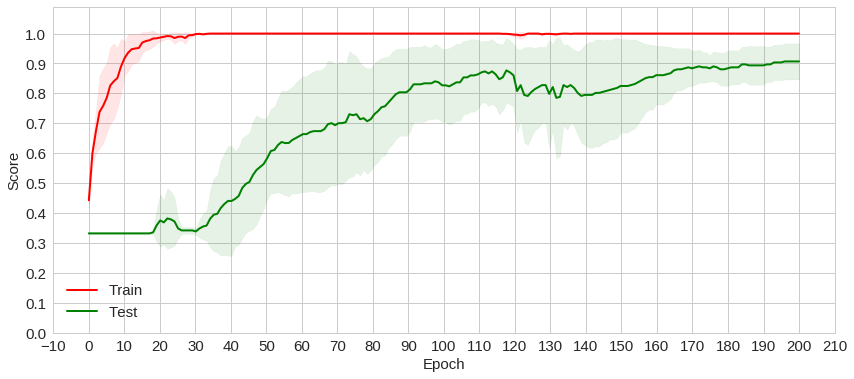

In [31]:
plot_mean_acc(hist)

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-0.9,10.9))
    plt.show()

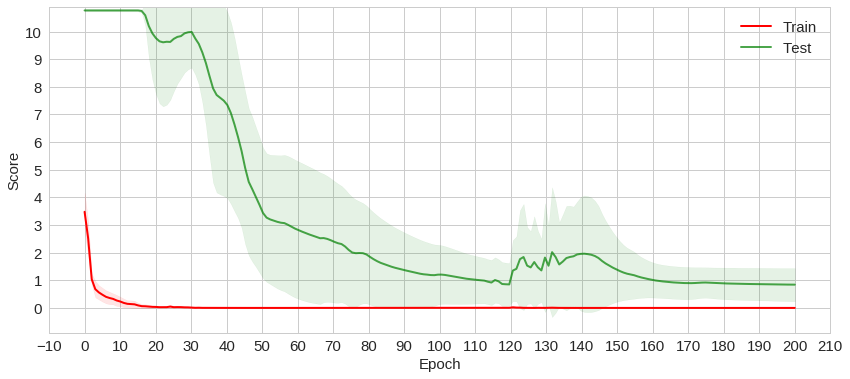

In [33]:
plot_mean_loss(hist)